In [1]:
!pwd

/home/alan_khang/adam_sandbox


In [1]:
import os.path as osp
import os
import sys
import glob
import pickle
import cv2
import numpy as np
import json
import time
import math
from scipy.spatial.transform import Rotation as R
from pyquaternion import Quaternion
from tqdm import tqdm

from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import Box
from nuscenes.nuscenes import NuScenes
from nuscenes.eval.detection.evaluate import NuScenesEval 
from nuscenes.eval.detection.config import config_factory

from mmdet3d.datasets.convert_utils import post_process_coords
from mmdet3d.structures.bbox_3d.utils import points_cam2img 

# Create nuScenes format

In [2]:
root_dir = '/home/alan_khang/Desktop/adam_dataset'

transporter_name = ['t1', 't2']
date_dir = ['2025_07_25', '2025_07_29', '2025_07_30', '2025_07_31', '2025_08_01', '2025_08_02', '2025_08_03']

des_dir = osp.join(root_dir, 'nuscenes_format')

In [3]:
attribute_table = [{
    "token": "attribute_0",
    "name": "guilder",
    "description": "guilder"
}]

if osp.exists(osp.join(des_dir, 'attribute.json')):
    os.remove(osp.join(des_dir, 'attribute.json'))

with open(osp.join(des_dir, 'attribute.json'), 'w') as f:
    json.dump(attribute_table, f, indent=4)

In [4]:
calibrated_sensor_table = [{
    "token": "cs_0",
    "sensor_token": "ss_0",
    "translation": [0.0, 0.0, 0.0],
    "rotation": [1.0, 0.0, 0.0, 0.0],
    "camera_intrinsic": [
        [427.2243957519531, 0.0, 320.0],
        [0.0, 427.2243957519531, 200.0],
        [0.0, 0.0, 1.0]
]}]

if osp.exists(osp.join(des_dir, 'calibrated_sensor.json')):
    os.remove(osp.join(des_dir, 'calibrated_sensor.json'))

with open(osp.join(des_dir, 'calibrated_sensor.json'), 'w') as f:
    json.dump(calibrated_sensor_table, f, indent=4)

In [5]:
category_table = [{
    "token": "cat_0",
    "name": "guilder",
    "description": "guilder"
}]

if osp.exists(osp.join(des_dir, 'category.json')):
    os.remove(osp.join(des_dir, 'category.json'))

with open(osp.join(des_dir, 'category.json'), 'w') as f:
    json.dump(category_table, f, indent=4)

In [6]:
log_table = [{
    "token": "log_0",
    "logfile": "...",
    "vehicle": "...",
    "date_captured": "...",
    "location": "..."
}]

if osp.exists(osp.join(des_dir, 'log.json')):
    os.remove(osp.join(des_dir, 'log.json'))

with open(osp.join(des_dir, 'log.json'), 'w') as f:
    json.dump(log_table, f, indent=4)

In [7]:
map_table = [{
    "category": "semantic_prior",
    "token": "map_0",
    "filename": "maps/map.png",
    "log_tokens": [
        "log_0"
    ]
}]

if osp.exists(osp.join(des_dir, 'map.json')):
    os.remove(osp.join(des_dir, 'map.json'))

with open(osp.join(des_dir, 'map.json'), 'w') as f:
    json.dump(map_table, f, indent=4)

In [8]:
cam_name = 'CAM_FRONT'

sensor_table = [{
    "token": "ss_0",
    "channel": cam_name,
    "modality": "camera"
}]

if osp.exists(osp.join(des_dir, 'sensor.json')):
    os.remove(osp.join(des_dir, 'sensor.json'))

with open(osp.join(des_dir, 'sensor.json'), 'w') as f:
    json.dump(sensor_table, f, indent=4)

In [9]:
visibility_table = [{
    "description": "visibility of whole object is between 80 and 100%",
    "token": "vis_0",
    "level": "v80-100"
}]

if osp.exists(osp.join(des_dir, 'visibility.json')):
    os.remove(osp.join(des_dir, 'visibility.json'))

with open(osp.join(des_dir, 'visibility.json'), 'w') as f:
    json.dump(visibility_table, f, indent=4)

In [10]:
ego_pose_table = []
instance_table = []
sample_table = []
sample_annotation_table = []
sample_data_table = []
scene_table = []

In [11]:
img_idx = 0
scene_idx = 0

for transporter in transporter_name:
    for date in date_dir:
        try:
            dataset_root = osp.join(root_dir, f'{transporter}_{date}')
            if not osp.exists(dataset_root):
                continue
            scenes_by_date = sorted(os.listdir(dataset_root))
            scenes_by_date = list(filter(lambda x: date in x, scenes_by_date))
            scenes_by_date = [osp.join(dataset_root, s) for s in scenes_by_date]
            scenes_by_date = [s for s in scenes_by_date if osp.isdir(s)]
            for scene in scenes_by_date:
                scene_name = osp.basename(scene)
                ignore_file_path = osp.join(scene, 'processed/ignore_file.txt')

                if not osp.exists(ignore_file_path):
                    print(f"Ignore file not found for {transporter}_{scene_name}, skipping...")
                    continue

                with open(ignore_file_path, 'r') as f:
                    ignore_files = f.readlines()
                ignore_files = [line.strip() for line in ignore_files]

                img_dir = osp.join(scene, 'processed/images')
                annot_dir = osp.join(scene, 'processed/annotations')
                img_files = sorted(glob.glob(osp.join(img_dir, '*.jpg')))
                annot_files = sorted(glob.glob(osp.join(annot_dir, '*.json')))
                assert len(img_files) == len(annot_files), f"Image and annotation counts do not match"
                if len(img_files) == 0:
                    continue

                scene_dict = {
                    "token": "scene_" + str(scene_idx),
                    "name": "scene_" + transporter + "_" + scene_name,
                    "description": "...",
                    "log_token": "log_0"}
                sample_token_list = []

                for img_file in tqdm(img_files):
                    img_filename = osp.basename(img_file)
                    assert img_file.endswith('.jpg'), f"Expected .jpg file, got {img_file}"

                    if img_filename in ignore_files:
                        continue

                    annot_file = img_file.replace('images', 'annotations').replace('.jpg', '.json')

                    with open(annot_file, 'r') as f:
                        annotations = json.load(f)

                    ego_pose_dict = {
                        "token": "ego_pose_" + str(img_idx),
                        "translation": [0.0, 0.0, 0.0],
                        "rotation": [1.0, 0.0, 0.0, 0.0],
                        "timestamp": annotations.get('timestamp', time.time()),
                        "log_token": "log_0"}

                    instance_dict = {
                        "token": "ins_" + str(img_idx),
                        "category_token": "cat_0",
                        "nbr_annotations": 1,
                        "first_annotation_token": "annot_" + str(img_idx),
                        "last_annotation_token": "annot_" + str(img_idx)}

                    sample_dict = {
                        "token": "sample_" + str(img_idx),
                        "timestamp": annotations.get('timestamp', time.time()),
                        "scene_token": "scene_" + str(scene_idx),
                        "next": "",
                        "prev": ""}
    
                    sample_data_dict = {
                        "token": "sample_data_" + str(img_idx),
                        "sample_token": "sample_" + str(img_idx),
                        "ego_pose_token": "ego_pose_" + str(img_idx),
                        "calibrated_sensor_token": "cs_0",
                        "filename": img_file,
                        "fileformat": "jpg",
                        "width": annotations.get('img_width', 640),
                        "height": annotations.get('img_height', 400),
                        "timestamp": annotations.get('timestamp', time.time()),
                        "is_key_frame": False,
                        "next": "",
                        "prev": ""}

                    camera_intr = np.array(annotations['camera_intrinsic'])
                    assert camera_intr.tolist() == calibrated_sensor_table[0]['camera_intrinsic'], \
                        f"Camera intrinsic mismatch for {img_filename}"
                    guilder_whl = np.array(annotations['guilder_whl'])
                    guilder_center = np.array(annotations['guilder_center'])
                    pitch_angle_deg = annotations['guilder_pitch_deg']

                    guilder_wlh = np.array([
                        guilder_whl[0], 
                        guilder_whl[2], 
                        guilder_whl[1]])  # convert wlh to lhw

                    quat = R.from_euler(
                        'z', 
                        -pitch_angle_deg, 
                        degrees=True).as_quat(scalar_first=True).squeeze()

                    sample_annotation_dict = {
                        "token": "sample_annotation_" + str(img_idx),
                        "sample_token": "sample_" + str(img_idx),
                        "instance_token": "ins_" + str(img_idx),
                        "attribute_tokens": ["attribute_0"],
                        "visibility_token": "vis_0",
                        "translation": guilder_center.tolist(),
                        "size": guilder_wlh.tolist(),
                        "rotation": quat.tolist(),
                        "num_lidar_pts": 0,
                        "num_radar_pts": 0,
                        "next": "",
                        "prev": ""}

                    ego_pose_table.append(ego_pose_dict)
                    instance_table.append(instance_dict)
                    sample_table.append(sample_dict)
                    sample_annotation_table.append(sample_annotation_dict)
                    sample_data_table.append(sample_data_dict)

                    sample_token_list.append("sample_" + str(img_idx))
                    img_idx += 1

                if len(sample_token_list) == 0:
                    print(f"No valid samples found in {transporter}_{scene_name}, skipping...")
                    continue
                
                scene_dict['nbr_samples'] = len(sample_token_list)
                scene_dict['first_sample_token'] = sample_token_list[0]
                scene_dict['last_sample_token'] = sample_token_list[-1]

                scene_table.append(scene_dict)

                scene_idx += 1

        except Exception as e:
            print(f"Error processing {transporter} on {scene}: {e}")
            continue

if osp.exists(osp.join(des_dir, 'ego_pose.json')):
    os.remove(osp.join(des_dir, 'ego_pose.json'))
with open(osp.join(des_dir, 'ego_pose.json'), 'w') as f:
    json.dump(ego_pose_table, f, indent=4)

if osp.exists(osp.join(des_dir, 'instance.json')):
    os.remove(osp.join(des_dir, 'instance.json'))
with open(osp.join(des_dir, 'instance.json'), 'w') as f:
    json.dump(instance_table, f, indent=4)

if osp.exists(osp.join(des_dir, 'sample.json')):  
    os.remove(osp.join(des_dir, 'sample.json'))
with open(osp.join(des_dir, 'sample.json'), 'w') as f:
    json.dump(sample_table, f, indent=4)

if osp.exists(osp.join(des_dir, 'sample_annotation.json')):
    os.remove(osp.join(des_dir, 'sample_annotation.json'))
with open(osp.join(des_dir, 'sample_annotation.json'), 'w') as f:
    json.dump(sample_annotation_table, f, indent=4)

if osp.exists(osp.join(des_dir, 'sample_data.json')):
    os.remove(osp.join(des_dir, 'sample_data.json'))
with open(osp.join(des_dir, 'sample_data.json'), 'w') as f:
    json.dump(sample_data_table, f, indent=4)

if osp.exists(osp.join(des_dir, 'scene.json')):
    os.remove(osp.join(des_dir, 'scene.json'))
with open(osp.join(des_dir, 'scene.json'), 'w') as f:
    json.dump(scene_table, f, indent=4)

100%|██████████| 1/1 [00:00<00:00, 14364.05it/s]


No valid samples found in t1_2025_07_25:17:29:11, skipping...


100%|██████████| 6/6 [00:00<00:00, 167772.16it/s]


No valid samples found in t1_2025_07_25:21:24:23, skipping...


  0%|          | 0/793 [00:00<?, ?it/s]

100%|██████████| 219/219 [00:00<00:00, 14349.47it/s]


# Check label

In [12]:
import numpy as np

from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import Box
from nuscenes.nuscenes import NuScenes
from nuscenes.eval.detection.evaluate import NuScenesEval 
from nuscenes.eval.detection.config import config_factory

In [13]:
adam_nuscenes_format_dataset_root = '/home/alan_khang/Desktop/adam_dataset'

nusc = NuScenes(
    version='', 
    dataroot=adam_nuscenes_format_dataset_root, 
    verbose=True)

Loading NuScenes tables for version ...
1 category,
1 attribute,
1 visibility,
3121 instance,
1 sensor,
1 calibrated_sensor,
3121 ego_pose,
1 log,
24 scene,
3121 sample,
3121 sample_data,
3121 sample_annotation,
1 map,
Done loading in 0.267 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [32]:
random_idx = np.random.randint(0, len(nusc.sample_data))
data_sample_token = 'sample_data_' + str(random_idx)

data_path, box_list, cam_intr = nusc.get_sample_data(data_sample_token)

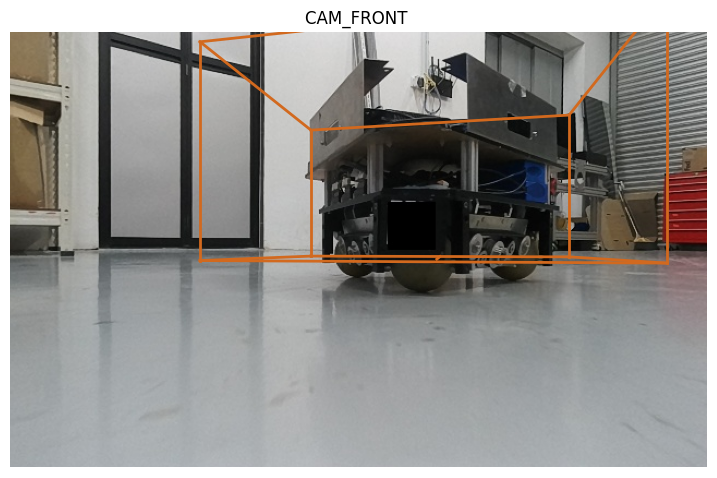

In [33]:
nusc.render_sample_data(data_sample_token)

In [35]:
nusc.scene

[{'token': 'scene_0',
  'name': 'scene_t1_2025_07_25:17:19:54',
  'description': '...',
  'log_token': 'log_0',
  'nbr_samples': 13,
  'first_sample_token': 'sample_0',
  'last_sample_token': 'sample_12'},
 {'token': 'scene_1',
  'name': 'scene_t1_2025_07_25:17:21:52',
  'description': '...',
  'log_token': 'log_0',
  'nbr_samples': 41,
  'first_sample_token': 'sample_13',
  'last_sample_token': 'sample_53'},
 {'token': 'scene_2',
  'name': 'scene_t1_2025_07_25:17:24:21',
  'description': '...',
  'log_token': 'log_0',
  'nbr_samples': 33,
  'first_sample_token': 'sample_54',
  'last_sample_token': 'sample_86'},
 {'token': 'scene_3',
  'name': 'scene_t1_2025_07_25:19:25:35',
  'description': '...',
  'log_token': 'log_0',
  'nbr_samples': 32,
  'first_sample_token': 'sample_87',
  'last_sample_token': 'sample_118'},
 {'token': 'scene_4',
  'name': 'scene_t1_2025_07_25:21:28:26',
  'description': '...',
  'log_token': 'log_0',
  'nbr_samples': 18,
  'first_sample_token': 'sample_119',
 

# Create mmdet3d style

In [34]:
from utils import get_corners
import math
import pickle
import datetime
from scipy.spatial.transform import Rotation as R
import shutil

from nuscenes.utils.splits import adam_eval

In [35]:
datetime_str = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
mmdet3d_format_data_train = {
    'metainfo': {
        'categories': {'guilder': 0},
        'dataset': 'adam_project',
        'version': '',
        'info_version': ''
    },
    'data_list': []
}
mmdet3d_format_data_val = {
    'metainfo': {
        'categories': {'guilder': 0},
        'dataset': 'adam_project',
        'version': '',
        'info_version': ''
    },
    'data_list': []
}

pkl_train_path = osp.join(des_dir, 'guilder_infos_train.pkl')
pkl_val_path = osp.join(des_dir, 'guilder_infos_val.pkl')

if osp.exists(pkl_train_path):
    os.remove(pkl_train_path)
if osp.exists(pkl_val_path):
    os.remove(pkl_val_path)

adam_eval_scene_name = adam_eval
eval_samples = []

for i, scene_token in enumerate(adam_eval):
    for scene in nusc.scene:
        if scene['name'] == scene_token:
            first_sample_token = scene['first_sample_token']
            last_sample_token = scene['last_sample_token']
            eval_samples.append((first_sample_token, last_sample_token))

In [36]:
for i, sample_data in enumerate(nusc.sample_data):
    sample_data_token = sample_data['token']

    is_eval = False
    for first_sample_token, last_sample_token in eval_samples:
        first_sample_token_int = int(first_sample_token.replace('sample_', ''))
        last_sample_token_int = int(last_sample_token.replace('sample_', ''))
        sample_data_token_int = int(sample_data_token.replace('sample_data_', ''))
        if first_sample_token_int <= sample_data_token_int <= last_sample_token_int:
            is_eval = True

    sensor_id = 0 
    cam_name = nusc.sensor[sensor_id]['channel']

    annot = nusc.get_sample_data(sample_data_token, box_vis_level=2)
    img_abs_path, guilder_annots, camera_intr = annot

    if len(guilder_annots) == 0:
        continue
    guilder_annot = guilder_annots[0]

    guilder_wlh = np.array(guilder_annot.wlh) 
    guilder_whl = guilder_wlh.copy()
    guilder_whl[[0, 1, 2]] = guilder_whl[[0, 2, 1]]
    guilder_center = np.array(guilder_annot.center)
    guilder_rot_by_y_rad = guilder_annot.orientation.yaw_pitch_roll[0]
    guilder_rot_by_y_deg = math.degrees(guilder_rot_by_y_rad)

    corners_3d = get_corners(guilder_center, guilder_whl, guilder_rot_by_y_deg)
    in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
    corners_3d = corners_3d[:, in_front]

    corner_coords = view_points(
        corners_3d, 
        camera_intr,
        True).T[:, :2].tolist()

    # Keep only corners that fall within the image.
    final_coords = post_process_coords(corner_coords)

    # Skip if the convex hull of the re-projected corners
    # does not intersect the image canvas.
    if final_coords is None:
        continue
    else:
        min_x, min_y, max_x, max_y = final_coords

    image_info = {
        cam_name: {
            'img_path': img_abs_path.replace(root_dir, '')[1:],
            'cam2img': camera_intr.tolist(),
            'cam2ego': np.eye(4).tolist(),
            'sample_data_token': sample_data_token,
            'timestamp': sample_data['timestamp'],
            'lidar2cam': np.eye(4).tolist()}}

    loc = guilder_center.tolist()

    guilder_lhw = guilder_whl.copy()
    guilder_lhw[[0, 1, 2]] = guilder_lhw[[2, 1, 0]]  # convert whl to lhw
    dim = guilder_lhw.tolist()

    rot = [guilder_rot_by_y_rad - (math.pi / 2)]

    center_3d = np.array(loc).reshape([1, 3])
    center_2d_with_depth = points_cam2img(center_3d, camera_intr, with_depth=True)
    center_2d_with_depth = center_2d_with_depth.squeeze().tolist()

    cam_instances = {
        cam_name: [{
            'bbox_label': 0, 
            'bbox_label_3d': 0, 
            'bbox': [min_x, min_y, max_x, max_y], 
            'bbox_3d_isvalid': True, 
            'bbox_3d': loc + dim + rot, 
            'velocity': [0., 0.], 
            'center_2d': center_2d_with_depth[:2], 
            'depth': center_2d_with_depth[2], 
            'attr_label': 0}]}

    data_sample = {
        'sample_idx': i,
        'token': sample_data['sample_token'],
        'timestamp': sample_data['timestamp'],
        'ego2global': np.eye(4).tolist(),   
        'images': image_info,
        'cam_instances': cam_instances
    }

    if is_eval:
        mmdet3d_format_data_val['data_list'].append(data_sample)
    else:
        mmdet3d_format_data_train['data_list'].append(data_sample)

# Save to .pkl file
with open(pkl_train_path, 'wb') as f:
    pickle.dump(mmdet3d_format_data_train, f)
with open(pkl_val_path, 'wb') as f:
    pickle.dump(mmdet3d_format_data_val, f)

In [21]:
with open(pkl_val_path, 'rb') as f:
    guilder_val = pickle.load(f)
    

In [22]:
len(guilder_val['data_list'])

517

In [31]:
guilder_val['data_list'][10]['cam_instances']['CAM_FRONT'][0]['bbox_3d']

[-0.2035244827270508,
 -0.1497774948179722,
 1.091216538310051,
 0.488,
 0.304,
 0.58,
 -1.6807675493035616]

In [20]:
rot =guilder_data['data_list'][100]['cam_instances']['CAM_FRONT'][0]['bbox_3d'][-1]

In [21]:
sample_data_tok = guilder_data['data_list'][100]['images']['CAM_FRONT']['sample_data_token']

In [22]:
rot

-1.469015812054562

In [23]:
nusc.get_sample_data(sample_data_tok)[1][0].orientation.yaw_pitch_roll[1]

0.10178051474033463

In [24]:
round(math.pi / 2 + rot, 5) == \
    round(nusc.get_sample_data(sample_data_tok)[1][0].orientation.yaw_pitch_roll[1], 5)

True

In [25]:
len(guilder_data['data_list'])

1155